In [1]:
import tensorflow as tf
import numpy as np
from utils import aug_utils, bbox_utils, anchor_utils

class DataLoader():
    def __init__(self, dtype, labels, batch_size, anchors, input_size, 
                 strides, positive_iou_threshold, max_bboxes, create_anchors):
        self.dtype = dtype
        self.labels = labels
        self.batch_size = batch_size
        self.col_anchors = len(anchors[0])
        self.row_anchors = len(anchors)
        self.num_classes = len(labels)
        self.input_size = input_size
        self.strides = np.array(strides)
        self.scales = (self.input_size // np.array(self.strides)).tolist()
        self.anchors = anchors
        self.anchors_xywh = anchor_utils.get_anchors_xywh(anchors, self.strides, self.input_size)
        self.positive_iou_threshold = positive_iou_threshold
        self.max_bboxes = max_bboxes
        self.create_anchors = create_anchors
        self._length = {}

    def __call__(self, split, use_tfrecord=True, use_label=False):
        if self.dtype == 'voc':
            from datasets.voc_dataset import Dataset
        elif self.dtype == 'coco':
            from datasets.coco_dataset import Dataset
        elif self.dtype == 'custom':
            from datasets.custom_dataset import Dataset
        elif self.dtype == 'raw':
            from datasets.raw_dataset import Dataset
        dataset = Dataset(split, self.dtype, self.anchors, self.labels, self.input_size, self.create_anchors)

        data = dataset.load(use_tfrecord)
        self._length[split] = dataset.length

        data = data.cache()

        if split == 'train':
            tf.random.set_seed(42)
            data = data.shuffle(buffer_size = min(self.length(split) * 3, 200000), seed=42)
            
        # if you have enough ram move this line before data.cache(), it will be faster
        data = data.map(self.tf_preprocessing, num_parallel_calls=-1) 

        if split == 'train':
            data = data.map(lambda image, labels, width, height: aug_utils.tf_augmentation(image, labels, width, height, self.input_size), num_parallel_calls=-1)
            data = data.map(self.tf_minmax, num_parallel_calls=-1)
            data = data.map(lambda image, labels, width, height: aug_utils.tf_resize_random_padding(image, labels, width, height, self.input_size), num_parallel_calls=-1)
        else:
            data = data.map(lambda image, labels, width, height: aug_utils.tf_resize_padding(image, labels, width, height, self.input_size), num_parallel_calls=-1)
        data = data.padded_batch(self.batch_size, padded_shapes=self.get_padded_shapes(), padding_values=self.get_padding_values(), drop_remainder=True)

        # data = data.map(lambda x, y: self.py_labels_to_grids(x, y, use_label), num_parallel_calls=-1).prefetch(1)
        data = data.map(lambda image, labels: self.tf_encode(image, labels, use_label), num_parallel_calls=-1).prefetch(1)
        return data
    
    def length(self, split):
        return self._length[split]
    
    def py_encode(self, image, labels, use_label):
        grids = tf.py_function(self.encode, [labels], [tf.float32]*self.row_anchors)
        if use_label:
            return image, *grids, labels
        return image, *grids
    
    @tf.function
    def tf_preprocessing(self, image, labels, width, height):
        image = tf.cast(image, tf.float32)/255.
        return image, labels, width, height
    
    def tf_minmax(self, image, labels, width, height):
        return tf.maximum(tf.minimum(image, 1.), 0), labels, width, height
    
    @tf.function
    def tf_resize_padding(self, image, labels, width, height):
        image, labels = aug_utils.tf_resize_padding(image, labels, width, height, self.input_size)

        return image, labels
    
    @tf.function
    def tf_encode(self, image, labels, use_label):
        grids = self.encode2(labels)
        if use_label:
            return image, *grids, labels
        return image, *grids
    
    @tf.function
    def onehot_label(self, prob, smooth=True, alpha=0.1):
        onehot = tf.one_hot(tf.cast(prob, dtype=tf.int32), self.num_classes)
        if smooth:
            return onehot * (1. - alpha) + alpha/self.num_classes
        return onehot

    @tf.function
    def encode(self, labels):
        labels = bbox_utils.xyxy_to_xywh(labels, True)
        conf = labels[..., 4:5]

        onehot = conf * self.onehot_label(labels[..., 5], smooth=True)

        grids = []
        anchor_xy = [tf.reshape(anchor[..., :2], [-1,2]) for anchor in self.anchors_xywh]
        anchor_wh = [tf.reshape(anchor[..., 2:], [-1,2]) for anchor in self.anchors_xywh]

        center_anchors = tf.concat([tf.concat([anchor_xy[i] + 0.5, anchor_wh[i]], -1) * self.strides[i] for i in range(self.row_anchors)], 0)

        ious = bbox_utils.bbox_iou(center_anchors[:, None], labels[:, None, ..., :4])

        # assign maximum label
        maximum_positive_ious = tf.where(tf.greater_equal(ious, self.positive_iou_threshold), ious, 0.)

        # assign minimum label
        best_anchor_iou = tf.reduce_max(ious, -2, keepdims=True)
        minimum_positive_ious = tf.where(tf.logical_and(ious == best_anchor_iou, ious > 0), best_anchor_iou, 0.)
    
        # join minimum, maximum label
        joined_ious = tf.where(tf.cast(minimum_positive_ious, tf.bool), minimum_positive_ious, maximum_positive_ious)
        joined_positive_mask = tf.cast(tf.reduce_any(tf.cast(joined_ious, tf.bool), -1, keepdims=True), tf.float32)

        assigned_labels = tf.gather(tf.concat([labels[..., :5], onehot],-1), tf.argmax(joined_ious, -1), batch_dims=1) * joined_positive_mask

        for i in range(self.row_anchors):
            scale = self.scales[i]
            start = 0 if i==0 else tf.reduce_sum((self.input_size//self.strides[:i])**2 * self.col_anchors)
            end = start + (scale)**2 * self.col_anchors
            grids += [tf.reshape(assigned_labels[:, start:end], [self.batch_size, scale, scale, self.col_anchors, -1])]

        return grids

    @tf.function
    def encode2(self, labels):
        labels = bbox_utils.xyxy_to_xywh(labels, True)
        conf = labels[..., 4:5]

        onehot = conf * self.onehot_label(labels[..., 5], smooth=True)

        grids = []
        anchor_xy = [tf.reshape(anchor[..., :2], [-1,2]) for anchor in self.anchors_xywh]
        anchor_wh = [tf.reshape(anchor[..., 2:], [-1,2]) for anchor in self.anchors_xywh]

        center_anchors = tf.concat([tf.concat([anchor_xy[i] + 0.5, anchor_wh[i]], -1) * self.strides[i] for i in range(self.row_anchors)], 0)

        ious = bbox_utils.bbox_iou(center_anchors[:, None], labels[:, None, ..., :4])

        # assign maximum label
        maximum_positive_ious = tf.where(tf.greater_equal(ious, self.positive_iou_threshold), ious, 0.)     

        # assign minimum label
        best_anchor_iou = tf.reduce_max(ious, -2, keepdims=True)
        minimum_positive_ious = tf.where(tf.logical_and(ious == best_anchor_iou, ious > 0), best_anchor_iou, 0.)
    
        # join minimum, maximum label
        joined_ious = tf.where(tf.cast(minimum_positive_ious, tf.bool), minimum_positive_ious, maximum_positive_ious)
        joined_positive_mask = tf.cast(tf.reduce_any(tf.cast(joined_ious, tf.bool), -1, keepdims=True), tf.float32)

        assigned_labels = tf.gather(tf.concat([labels[..., :5], onehot],-1), tf.argmax(joined_ious, -1), batch_dims=1) * joined_positive_mask
        grid_xy = tf.concat([anchor_xy[i] for i in range(self.row_anchors)], 0)
        tiled_strides = tf.cast(tf.concat([tf.tile(stride[None, None, None], [self.batch_size, scale**2*self.col_anchors, 1]) for stride, scale in zip(self.strides, self.scales)], 1), tf.float32)
        based_xy = (grid_xy[None] - tf.minimum(tf.maximum(grid_xy[None] - assigned_labels[..., :2] / tiled_strides, -1), 0)) * joined_positive_mask * tiled_strides
        assigned_labels = tf.concat([based_xy, assigned_labels[..., 2:]], -1)

        for i in range(self.row_anchors):
            scale = self.scales[i]
            start = 0 if i==0 else tf.reduce_sum((self.input_size//self.strides[:i])**2 * self.col_anchors)
            end = start + (scale)**2 * self.col_anchors
            grids += [tf.reshape(assigned_labels[:, start:end], [self.batch_size, scale, scale, self.col_anchors, -1])]

        return grids
    
    @tf.function
    def get_padded_shapes(self):
        return [None, None, None], [self.max_bboxes, None]

    @tf.function
    def get_padding_values(self):
        return tf.constant(0, tf.float32), tf.constant(0, tf.float32)

In [2]:
import cv2
from config import *
input_size = 1280
dataloader = DataLoader(DTYPE, LABELS, BATCH_SIZE, ANCHORS, input_size, [8,16,32], 0.5, 100, False)

2023-08-25 14:55:21.773229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 14:55:21.788150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 14:55:21.788319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 14:55:21.789253: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
data = dataloader('val', use_label=True)

/home/hs/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: custom val
./data/custom/val.tfrecord is exist


In [4]:
d = next(iter(data))

In [5]:
i, s, m, l, gts = d
s_color = (255, 0, 0)
m_color = (0, 255, 0)
l_color = (0, 0, 255)
gt_color = (0, 0, 0)

index = 3
image = i.numpy()[index][..., ::-1]*255
small = s.numpy()[index]
medium = m.numpy()[index]
large = l.numpy()[index]
gt = gts.numpy()[index]
group = [[small, s_color], [medium, m_color], [large, l_color], [gt, gt_color]]


s = 8
# for i in range(0, input_size, s):
#     cv2.line(image, (0, i), (input_size, i), (255,255,255, 1))
#     cv2.line(image, (i, 0), (i, input_size), (255,255,255, 1))
    
for i, (sml, color) in enumerate(group):
    for label in sml.reshape([-1, sml.shape[-1]]):
        box = label[:4]
        if i!=3:
            box = bbox_utils.xywh_to_xyxy(box).numpy()
        if i in [10]:
            break
        wh = ((box[:2] + box[2:]) * 0.5).astype(np.int32)
        box = box.astype(np.int32)
        
        if label[5]==0:
            continue
        cv2.rectangle(image, box[:2], box[2:], color, 1)
        
        cv2.circle(image, wh, 2, color, 1)
        # print(box)

# cv2.imshow('image', image.astype(np.uint8))
# cv2.waitKey()
# cv2.destroyAllWindows()

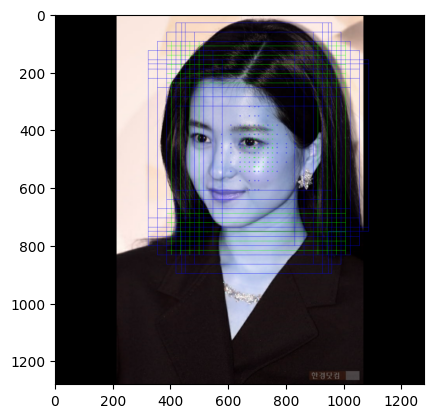

In [6]:
import matplotlib.pyplot as plt
plt.imshow(image.astype(np.uint8))
plt.show()

In [6]:
# image = cv2.resize(image, (1248,1248))

cv2.imshow('image', image.astype(np.uint8))
cv2.waitKey()
cv2.destroyAllWindows()

In [3]:
from utils.train_utils import load_model
from models.backbones import *
from models.necks import *
from models.heads import *
from config import *
import tensorflow as tf
from tensorflow.keras.initializers import GlorotUniform as glorot
# model, _, _, _, _ = load_model(MODEL_TYPE, ANCHORS, NUM_CLASSES, STRIDES, IOU_THRESHOLD, EPS, INF, KERNEL_INITIALIZER, LOAD_CHECKPOINTS, CHECKPOINTS)

In [19]:
img = tf.zeros((1, 512,512,3))
scale = [64,32,16]
backbone = CSPDarknet53(activate='Mish', scaled=True, kernel_initializer=glorot)
panspp = PANSPP(512, layer_size=3, block_size=2, branch_transition=True,
                               activate='LeakyReLU', kernel_initializer=glorot)
csppanspp = CSPPANSPP(512, layer_size=3, block_size=2, branch_transition=True,
                                  activate='Mish', kernel_initializer=glorot)
head = YoloHead(256, scale, 3, 80, 'Mish', kernel_initializer=glorot)

In [20]:
b = backbone(img)

In [23]:
n1 = panspp(temp)
h1 = head(n1)

In [24]:
n2 = csppanspp(temp)
h2 = head(n2)

In [28]:
h2[2]

<tf.Tensor: shape=(1, 16, 16, 3, 85), dtype=float32, numpy=
array([[[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],


        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
       

In [7]:
from utils.bbox_utils import bbox_iou
import numpy as np
import tensorflow as tf

a=np.zeros((4))[None]
b=np.zeros((0, 4))
iou = bbox_iou(a, b)

In [5]:
a=tf.zeros((0,4))
while(a.shape[0]):
    print(a.shape)
    break

In [8]:
iou.shape

TensorShape([0])

In [1]:
from utils import data_utils, train_utils, io_utils, eval_utils, post_processing, anchor_utils, bbox_utils
from config import *
import tensorflow as tf
import numpy as np
import cv2
tf.random.set_seed(42)
dataloader = data_utils.DataLoader(DTYPE, LABELS, BATCH_SIZE, ANCHORS, 416, 
                                       [8,16,32], POSITIVE_IOU_THRESHOLD, MAX_BBOXES, CREATE_ANCHORS)


2023-08-07 12:24:56.551313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-07 12:24:56.566462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-07 12:24:56.566540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-07 12:24:56.567005: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:

t = dataloader('train', use_label=True)

/home/dblab/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: voc train
./data/voc/train.tfrecord is exist


In [3]:
tt = next(iter(t))

In [4]:
tt[4]

<tf.Tensor: shape=(16, 100, 6), dtype=float32, numpy=
array([[[ 87.,  -1., 381., 383.,   1.,  12.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]],

       [[ 96., 196., 198., 255.,   1.,  13.],
        [118., 197., 228., 254.,   1.,  14.],
        [182., 185., 250., 204.,   1.,  14.],
        ...,
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]],

       [[187., 237., 205., 261.,   1.,  19.],
        [217., 323., 230., 336.,   1.,  19.],
        [226., 384., 238., 401.,   1.,  19.],
        ...,
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]],

       ...,

       [[265., 339., 277., 411.,   1.,   3.],
        [248.,

In [5]:
i, s, m, l, gt = tt

In [6]:
image = (i[0] * 255).numpy().astype(np.uint8)
label = gt[0].numpy().astype(np.int32)

In [7]:
cv2.rectangle(image, label[0][:2], label[0][2:4], (255,255, 0), 1)
cv2.imshow('image', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [8]:
image.shape

(416, 416, 3)

In [11]:
tf.random.set_seed(42)
print(tf.random.uniform(()))
tf.random.set_seed(42)
print(tf.random.uniform(()))

tf.Tensor(0.6645621, shape=(), dtype=float32)
tf.Tensor(0.6645621, shape=(), dtype=float32)


In [60]:
print(tf.random.uniform(()))

tf.Tensor(0.7413678, shape=(), dtype=float32)


In [20]:
bboxes = np.zeros((10,4))
bboxes[0] = [10,10,30,50]

In [21]:
def ro(bboxes):
    bboxes = np.stack([bboxes[..., 1], 
                      100 - bboxes[..., 2] -1,
                      bboxes[..., 3],
                      100 - bboxes[..., 0] -1], -1)
    return bboxes
def fh(bboxes):
    bboxes = np.stack([100 - bboxes[..., 2] - 1,
                    bboxes[..., 1],
                    100 - bboxes[..., 0] - 1,
                    bboxes[..., 3]], -1)
    return bboxes

In [48]:
bboxes = ro(bboxes)
bboxes = fh(bboxes)
bboxes = ro(bboxes)

In [49]:
bboxes

array([[69., 49., 89., 89.],
       [99., 99., 99., 99.],
       [99., 99., 99., 99.],
       [99., 99., 99., 99.],
       [99., 99., 99., 99.],
       [99., 99., 99., 99.],
       [99., 99., 99., 99.],
       [99., 99., 99., 99.],
       [99., 99., 99., 99.],
       [99., 99., 99., 99.]])

In [4]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [39]:
def random_scale(image, bboxes, width, height, image_size, lower=0.7, upper=1.3):##
    rescaled_image_size = tf.random.uniform((), lower, upper) * image_size
    length = tf.cast(tf.reduce_max([width, height]), tf.float32)
    ratio = rescaled_image_size / length
    new_width = tf.round(width * ratio)
    new_height = tf.round(height * ratio)
    scaled_image = tf.image.resize(image, [new_height, new_width])
    scaled_bboxes = tf.round(bboxes * ratio)
    
    return scaled_image, scaled_bboxes, new_width, new_height

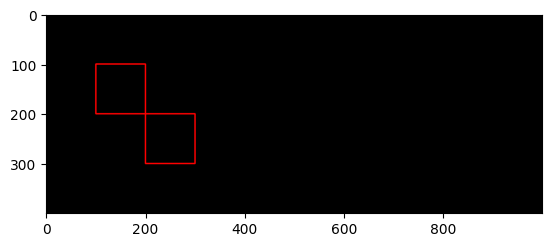

In [43]:
image = np.zeros((400, 1000, 3), np.uint8)
boxes = np.array([[100,100,200,200],[200,200,300,300]], np.float32)
for box in boxes.astype(np.int32):
    cv2.rectangle(image, box[:2],  box[2:], (255, 0, 0), 2)
plt.imshow(image)
plt.show()

In [44]:
scaled_image, scaled_bboxes, new_width, new_height = random_scale(image, boxes, 1000, 400, 400)

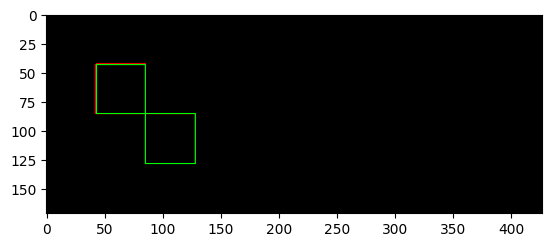

In [45]:
image2 = scaled_image.numpy().astype(np.uint8)
boxes2 = scaled_bboxes.numpy()
for box in boxes2.astype(np.int32):
    cv2.rectangle(image2, box[:2],  box[2:], (0, 255, 0), 1)
plt.imshow(image2)
plt.show()

In [48]:
np.array(image2.shape)

array([171, 427,   3])

In [50]:
boxes2/427 * 1000, boxes

(array([[100.702576, 100.702576, 199.06323 , 199.06323 ],
        [199.06323 , 199.06323 , 299.7658  , 299.7658  ]], dtype=float32),
 array([[100., 100., 200., 200.],
        [200., 200., 300., 300.]], dtype=float32))